In [62]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

%matplotlib inline

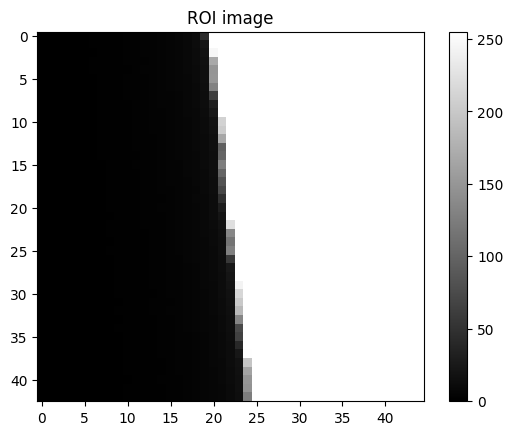

In [64]:
# load ROI image
image = np.load(r"..\quickMTF\sample_hori_edge.npy")
# image = np.load(r"..\quickMTF\sample_vert_edge.npy")
image = np.load(r"..\quickMTF\sample.npy")
# image = np.load(r"C:\Users\Lucas\Desktop\for\for Lucas\sample.npy")

fig, ax = plt.subplots()
im = ax.imshow(image, cmap='gray')
fig.colorbar(im, ax=ax)
plt.title("ROI image")
plt.show()

In [98]:
# algorithm parameters
supersampling = 4
sample = image
show_plots = 5
mtf_index = 0.5
sequence=0
return_fig = False

diff_kernel = np.array([0.5, 0.0, -0.5])
diff_offset = 0.0
diff_ft = 2  # factor used in the correction of the numerical derivation

In [99]:
# utilities
def angle_from_slope(slope):
    return np.rad2deg(np.arctan(slope))

def cubic_solver(a, b, c, d):
    # Solve the equation a*x**3 + b*x**2 + c*x + d = 0 for a
    # real-valued root x by Cardano's method
    # (https://en.wikipedia.org/wiki/Cubic_equation#Cardano's_formula)

    p = (3 * a * c - b ** 2) / (3 * a ** 2)
    q = (2 * b ** 3 - 9 * a * b * c + 27 * a ** 2 * d) / (27 * a ** 3)

    # A real root exists if 4 * p**3 + 27 * q**2 > 0
    sr = np.sqrt(q ** 2 / 4 + p ** 3 / 27)
    t = np.cbrt(-q / 2 + sr) + np.cbrt(-q / 2 - sr)
    x = t - b / (3 * a)
    return x


def dot(a, b):
    return a[0] * b[0] + a[1] * b[1]
        
def slope_from_angle(angle):
    return np.tan(np.deg2rad(angle))

def peak_width(y, rel_threshold):
    # Find width of peak in y that is above a certain fraction of the maximum value
    val = np.abs(y)
    val_threshold = rel_threshold * np.max(val)
    indices = np.where(val - val_threshold > 0.0)[0]
    return indices[-1] - indices[0]
        
def differentiate(arr, kernel):
    if len(arr.shape) == 2:
        # use 2-d convolution, but with a 1-d (row-oriented) kernel
        res = scipy.signal.convolve2d(arr, [kernel], 'same', 'symm')
    else:
        # input is a 1-d array
        res = np.convolve(arr, kernel, 'same')
        res[0] = 0.0
    return res

In [100]:
def centroid(arr, conv_kernel = 3, win_width = 5):
    height, width = arr.shape
    
    win = np.zeros(arr.shape)
    for i in range(height):
        win_c = np.argmax(np.abs(np.convolve(arr[i, :], np.ones(conv_kernel), 'same')))
        win[i, win_c - win_width:win_c + win_width] = 1.0
    x, _ = np.meshgrid(np.arange(width), np.arange(height))
    sum_arr = np.sum(arr * win, axis=1)
    sum_arr_x = np.sum(arr * win * x, axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        centr = sum_arr_x / sum_arr

    return centr, win, sum_arr, sum_arr_x

def find_edge(centr, patch_shape, rotated, angle=None, show_plots=False, verbose=False):
    idx = np.where(np.isfinite(centr))[0][1:-1]
    if angle is None:
        slope, offset = np.polyfit(idx, centr[idx], 1)
    else:
        slope = slope_from_angle(angle)
        offset = np.polyfit(idx, centr[idx] - slope * idx, 0)
    pcoefs = np.polyfit(idx, centr[idx], 2)
    angle = angle_from_slope(slope)

    return pcoefs, slope, offset,angle, idx, patch_shape, centr

def calc_distance(data_shape, p, quadratic_fit=False, verbose=False):
    # Calculate the distance (with sign) from each point (x, y) in the
    # image patch "data" to the slanted edge described by the polynomial p.
    # It is assumed that the edge is approximately vertically orientated
    # (between -45° and 45° from the vertical direction).
    # Distances to points to the left of the edge are negative, and positive
    # to points to the right of the edge.
    x, y = np.meshgrid(range(data_shape[1]), range(data_shape[0]))

    #verbose and print(f'quadratic fit: {str(quadratic_fit):s}')

    if not quadratic_fit or p[0] == 0.0:
        slope, offset = p[1], p[2]  # use linear fit to edge
        a, b, c = 1, -slope, -offset
        a_b = np.sqrt(a ** 2 + b ** 2)

        # |ax+by+c| / |a_b| is the distance from (x,y) to the slanted edge:
        dist = (a * x + b * y + c) / a_b
    else:
        # Define a cubic polynomial equation for the y-coordinate
        # y0 at the point (x0, y0) on the curved edge that is closest to (x, y)
        d = -y + p[1] * p[2] - x * p[1]
        c = 1 + p[1] ** 2 + 2 * p[2] * p[0] - 2 * x * p[0]
        b = 3 * p[1] * p[0]
        a = 2 * p[0] ** 2

        if p[0] == 0.0:
            y0 = -d / c  # solution if edge is straight (quadratic term is zero)
        else:
            y0 = cubic_solver(a, b, c, d)  # edge is curved

        x0 = p[0] * y0 ** 2 + p[1] * y0 + p[2]
        dxx_dyy = np.array(2 * p[0] * y0 + p[1])  # slope at (x0, y0)
        r2 = dot([1, -dxx_dyy], [1, -dxx_dyy])
        # distance between (x, y) and (x0, y0) along normal to curve at (x0, y0)
        dist = dot([x - x0, y - y0], [1, -dxx_dyy]) / np.sqrt(r2)
    return dist

def project_and_bin(data, dist, supersampling, verbose=True):


    bins = np.round(dist * supersampling).astype(int)
    bins = bins.flatten()
    bins -= np.min(bins)  # add an offset so that bins start at 0
    if np.max(bins) <=4 or np.max(bins) >=10000 :
        return False
    esf = np.zeros(np.max(bins) + 1)  # Edge spread function
    cnts = np.zeros(np.max(bins) + 1).astype(int)
    data_flat = data.flatten()
    for b_indx, b_sorted in zip(np.argsort(bins), np.sort(bins)):
        esf[b_sorted] += data_flat[b_indx]  # Collect pixel contributions in this bin
        cnts[b_sorted] += 1  # Keep a tab of how many contributions were made to this bin
    # Calculate mean by dividing by the number of contributing pixels. Avoid
    # division by zero, in case there are bins with no content.
    esf[cnts > 0] /= cnts[cnts > 0]
    if np.any(cnts == 0):
        if verbose:
            print("Warning: esf bins with zero pixel contributions were found. Results may be inaccurate.")
            print(f"Try reducing the supersampling factor, which currently is {supersampling:d}.")
        # Try to save the situation by patching in values in the empty bins if possible
        patch_cntr = 0
        for i in np.where(cnts == 0)[0]:  # loop through all empty bin locations
            j = [i - 1, i + 1]  # indices of nearest neighbors
            if j[0] < 0:  # Is left neighbor index outside esf array?
                j = j[1]
            elif j[1] == len(cnts):  # Is right neighbor index outside esf array?
                j = j[0]
            if np.all(cnts[j] > 0):  # Now, if neighbor bins are non-empty
                esf[i] = np.mean(esf[j])  # use the interpolated value
                patch_cntr += 1
        if patch_cntr > 0 and verbose:
            print(f"Values in {patch_cntr:d} empty ESF bins were patched by "
                  f"interpolation between their respective nearest neighbors.")
            # gui.window.log_message(f"Values in {patch_cntr:d} empty ESF bins were patched by "
            #       f"interpolation between their respective nearest neighbors.")
    return esf

def filter_window(lsf, supersampling, lsf_centering_kernel_sz=9,
                  win_width_factor=1.5, lsf_threshold=0.10):
    # The window ('hann_win') returned by this function will be used as a filter
    # on the LSF signal during the MTF calculation to reduce noise

    nn0 = 20 * supersampling  # sample range to be used for the FFT, intial guess
    mid = len(lsf) // 2
    i1 = max(0, mid - nn0)
    i2 = min(2 * mid, mid + nn0)
    nn = (i2 - i1) // 2  # sample range to be used, final


    # Filter LSF curve with a uniform kernel to better find center and
    # determine an appropriate Hann window width for noise reduction
    lsf_conv = np.convolve(lsf[i1:i2], np.ones(lsf_centering_kernel_sz), 'same')

    # Base Hann window half width on the width of the filtered LSF curve
    hann_hw = max(np.round(win_width_factor * peak_width(lsf_conv, lsf_threshold)).astype(int), 5 * supersampling)


    bin_c = np.argmax(np.abs(lsf_conv))  # center bin, corresponding to LSF max

    # Construct Hann window centered over the LSF peak, crop if necessary to
    # the range [0, 2*nn]
    crop_l = max(hann_hw - bin_c, 0)
    crop_r = min(2 * nn - (hann_hw + bin_c), 0)
    hann_win = np.zeros(2 * nn)  # default value outside Hann function
    hann_win[bin_c - hann_hw + crop_l:bin_c + hann_hw + crop_r] = \
        np.hanning(2 * hann_hw)[crop_l:2 * hann_hw + crop_r]
    return hann_win, 2 * hann_hw, [i1, i2]


def calc_mtf(lsf, hann_win, idx, supersampling, diff_ft):
    # Calculate MTF using the LSF as input and use the supplied window function
    # as filter to remove high frequency noise originating in regions far from
    # the edge

    i1, i2 = idx
    mtf = np.abs(np.fft.fft(lsf[i1:i2] * hann_win))
    nn = (i2 - i1) // 2
    mtf = mtf[:nn]
    mtf /= mtf[0]  # normalize to zero spatial frequency
    f = np.arange(0, supersampling / 2, supersampling / nn / 2)  # spatial frequencies (cy/px)
    # Compensate for finite impulse response of the numerical differentiaion
    # step used to derive the LSF from the ESF
    # NB: This compensation function is incorrect in both ISO 12233:2014
    # and ISO 12233:2017, Annex D
    mtf *= (1 / np.sinc(4 * f / (diff_ft * supersampling))).clip(0.0, 1.0)
    return np.column_stack((f, mtf))    

original ROI
(43,)


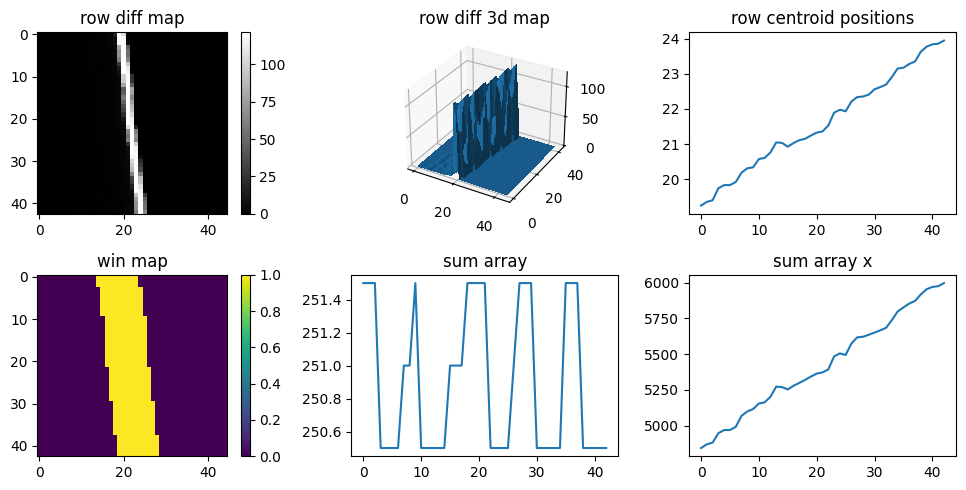

Rot90 ROI
(45,)


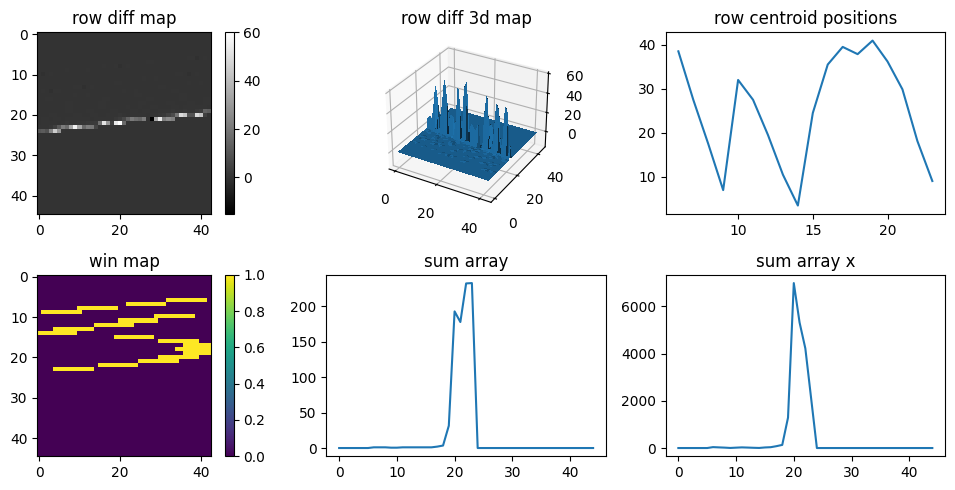

In [101]:
# calculate centroids for the edge transition of each row

def plot_centroid_and_stats(diff, centr, win, sum_arr, sum_arr_x):
    print(centr.shape)

    fig = plt.figure(figsize=(10, 5))

    ax00 = fig.add_subplot(2, 3, 1)
    ax00.set_title("row diff map")
    im00 = ax00.imshow(diff, cmap="gray")
    fig.colorbar(im00)

    ax01 = fig.add_subplot(2, 3, 2, projection="3d")
    X = np.arange(0, diff.shape[1])
    Y = np.arange(0, diff.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = diff
    surf = ax01.plot_surface(X, Y, Z,
                           linewidth=0, antialiased=False)
    ax01.set_title("row diff 3d map")

    ax02 = fig.add_subplot(2, 3, 3)
    ax02.set_title("row centroid positions")
    ax02.plot(centr)

    ax10 = fig.add_subplot(2, 3, 4)
    im10 = ax10.imshow(win)
    ax10.set_title("win map")
    fig.colorbar(im10)

    ax11 = fig.add_subplot(2, 3, 5)
    ax11.plot(sum_arr)
    ax11.set_title("sum array")

    ax12 = fig.add_subplot(2, 3, 6)
    ax12.plot(sum_arr_x)
    ax12.set_title("sum array x")
    
    plt.tight_layout()
    plt.show()

print("original ROI")
sample_diff = differentiate(image, diff_kernel)
sample_centr, sample_win, sample_sum_arr, sample_sum_arr_x = centroid(sample_diff)
sample_centr = sample_centr + diff_offset
plot_centroid_and_stats(sample_diff, sample_centr, sample_win, sample_sum_arr, sample_sum_arr_x)

# calculate centroids also for the 90deg right rotated image
print("Rot90 ROI")
image_rot90 = image.T[:, ::-1]  # rotate by transposing and mirroring
sample_diff_rot90 = differentiate(image_rot90, diff_kernel)
sample_centr_rot90, sample_win_rot90, sample_sum_arr_rot90, sample_sum_arr_x_rot90 = centroid(sample_diff_rot90)
sample_centr_rot90 = sample_centr_rot90 + diff_offset
plot_centroid_and_stats(sample_diff_rot90, sample_centr_rot90, sample_win_rot90, sample_sum_arr_rot90, sample_sum_arr_x_rot90)

27 0
Rotated: False
(43,)


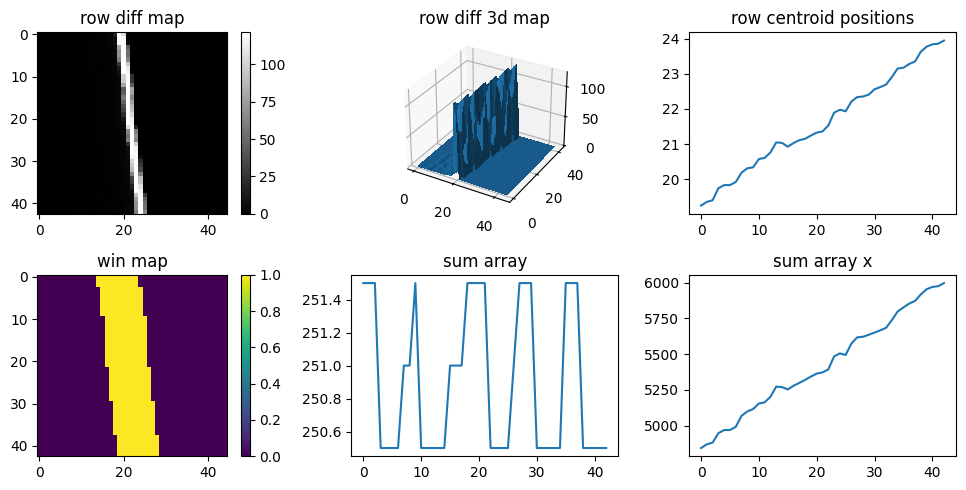

In [102]:
# Use rotated image if it results in fewer rows without edge transitions
def invalid_value_num(arr):
    nan_num = np.sum(np.isnan(arr))
    inf_num = np.sum(np.isinf(arr))
    return nan_num + inf_num
    
print(invalid_value_num(sample_centr_rot90), invalid_value_num(sample_centr))

if invalid_value_num(sample_centr_rot90) < invalid_value_num(sample_centr):
    (image_for_mtf, 
     diff_for_mtf, 
     centroid_for_mtf, 
     win_for_mtf, 
     sum_arr_for_mtf, 
     sum_arr_x_for_mtf) = (
         image_rot90, 
         sample_diff_rot90, 
         sample_centr_rot90, 
         sample_win, 
         sample_sum_arr, 
         sample_sum_arr_x)
    rotated = True
else:
    (image_for_mtf, 
     diff_for_mtf, 
     centroid_for_mtf, 
     win_for_mtf, 
     sum_arr_for_mtf, 
     sum_arr_x_for_mtf) = (
         image, 
         sample_diff, 
         sample_centr, 
         sample_win, 
         sample_sum_arr, 
         sample_sum_arr_x)    
    rotated = False

print(f"Rotated: {rotated}")
plot_centroid_and_stats(diff_for_mtf, centroid_for_mtf, win_for_mtf, sum_arr_for_mtf, sum_arr_x_for_mtf)

[2.88572056e-04 9.72319647e-02 1.94163866e+01] 0.10935199099249664 19.329526425051125 6.240611609625751
[0.0, np.float64(0.10935199099249664), np.float64(19.329526425051125)]
(43, 45)
False
(43, 45)


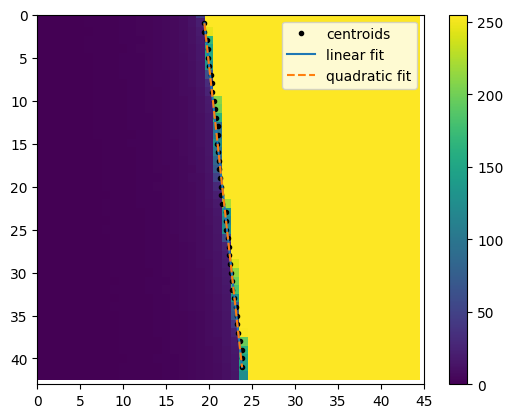

In [103]:
# find edge
pcoefs, slope, offset, angle, idx, patch_shape, centr = find_edge(centroid_for_mtf, image_for_mtf.shape, rotated, angle=None)
print(pcoefs, slope, offset, angle)

if abs(angle) < 0.9 : # ingore the less than 0.9 degree slant edge
     print("angle is less than 0.9 degs")

quadratic_fit = False

pcoefs = [0.0, slope, offset] if not quadratic_fit else pcoefs
print(pcoefs)

def plot_edge_and_stats(image_for_mtf, pcoefs, slope, offset, angle, idx, patch_shape, centr, rotated):
    fig, ax = plt.subplots()
    im = ax.imshow(image_for_mtf)
    plt.colorbar(im)
    if rotated:
        # ax.plot(patch_shape[1] - centr[idx], patch_shape[0] - idx, '.k', label="centroids")
        ax.plot(patch_shape[1] - np.polyval([slope, offset], idx), patch_shape[0] - idx, '-', label="linear fit")
        ax.plot(patch_shape[1] - np.polyval(pcoefs, idx), patch_shape[0] - idx, '--', label="quadratic fit")
        ax.set_xlim([0, patch_shape[1]])
        ax.set_ylim([0, patch_shape[0]])
    else:
        ax.plot(centr[idx], idx, '.k', label="centroids")
        ax.plot(np.polyval([slope, offset], idx), idx, '-', label="linear fit")
        ax.plot(np.polyval(pcoefs, idx), idx, '--', label="quadratic fit")
        ax.set_xlim([0, patch_shape[1]])
        ax.set_ylim([0, patch_shape[0]])
    #ax.text("{angle}")
    # ax.set_aspect('equal', 'box')
    ax.legend(loc='best')
    ax.invert_yaxis()

print(image_for_mtf.shape)
print(rotated)
print(patch_shape)
plot_edge_and_stats(image_for_mtf, pcoefs, slope, offset, angle, idx, patch_shape, centr, rotated)

(43, 45)


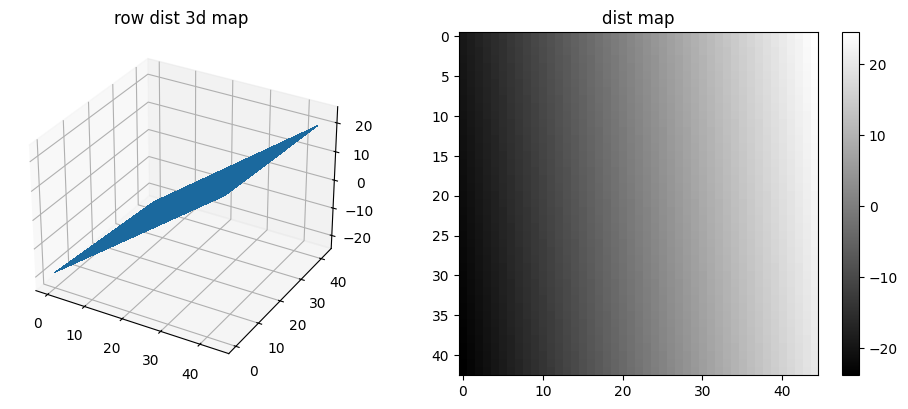

In [104]:
# Calculate distance (with sign) from each point (x, y) in the
# image patch "data" to the slanted edge
dist = calc_distance(image_for_mtf.shape, pcoefs, quadratic_fit=quadratic_fit)
print(dist.shape)

def plot_dist_and_stats(dist):
    fig = plt.figure(figsize=(10, 4))
    
    ax00 = fig.add_subplot(1, 2, 1, projection="3d")
    X = np.arange(0, dist.shape[1])
    Y = np.arange(0, dist.shape[0])
    X, Y = np.meshgrid(X, Y)
    Z = dist
    surf = ax00.plot_surface(X, Y, Z,
                           linewidth=0, antialiased=False)
    ax00.set_title("row dist 3d map")
    
    ax01 = fig.add_subplot(1, 2, 2)
    ax01.set_title("dist map")
    im0 = ax01.imshow(dist, cmap="gray")
    fig.colorbar(im0)

    plt.tight_layout()
    plt.show()

plot_dist_and_stats(dist)

(194,)


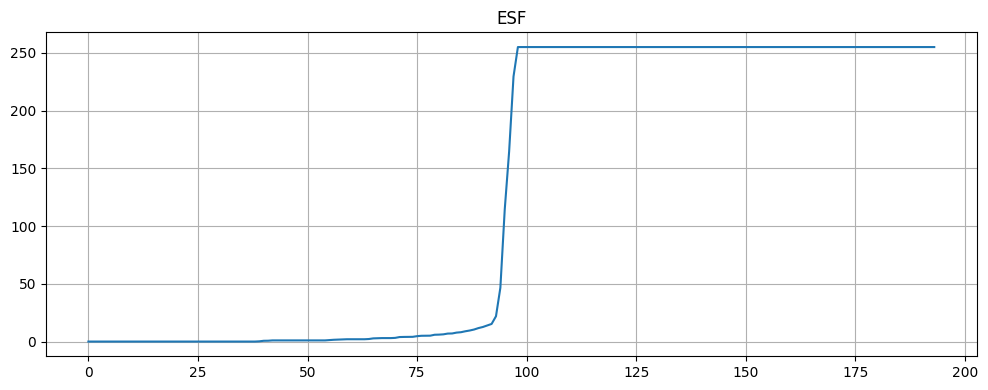

In [105]:
# ESF
esf = project_and_bin(image_for_mtf, dist, supersampling)  # edge spread function
print(esf.shape)
if esf is False:
    print("esf is invalid")

def plot_esf_and_stats(esf):
    fig = plt.figure(figsize=(10,4))

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(esf)
    ax.set_title("ESF")
    ax.grid()
    plt.tight_layout()
    plt.show()

plot_esf_and_stats(esf)

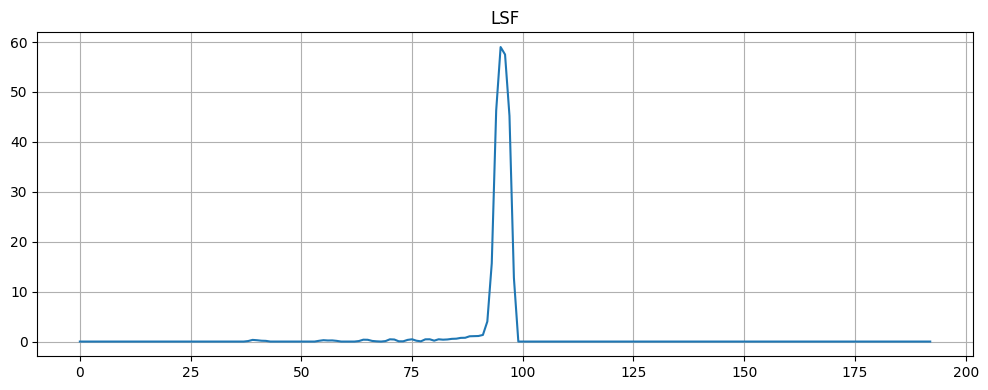

In [106]:
lsf = differentiate(esf, diff_kernel)  # line spread function


def plot_lsf_and_stats(lsf):
    fig = plt.figure(figsize=(10,4))

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lsf)
    ax.grid()
    ax.set_title("LSF")
    plt.tight_layout()
    plt.show()

plot_lsf_and_stats(lsf[0:-1])

40 [16, 176]


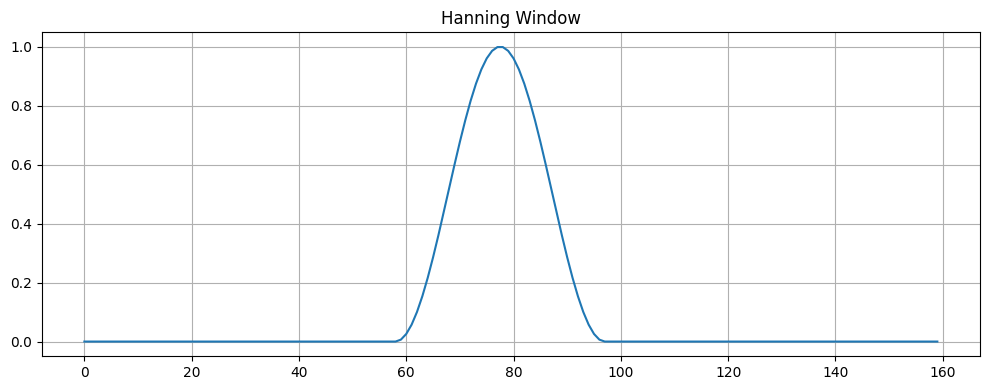

In [107]:
hann_win, hann_width, idx = filter_window(lsf[0:-1], supersampling)  # define window to be applied on LSF
if hann_width >350:  # sorting out no slant edge
    print("wrong!")

print(hann_width, idx)


def plot_filter_window_and_stats(hann_win):
    fig = plt.figure(figsize=(10,4))

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(hann_win)
    ax.set_title("Hanning Window")
    ax.grid()
    plt.tight_layout()
    plt.show()

plot_filter_window_and_stats(hann_win)

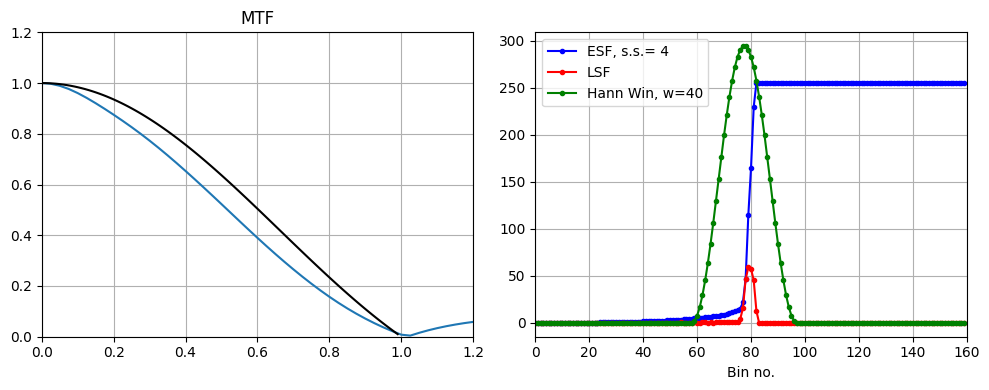

In [108]:
mtf = calc_mtf(lsf[0:-1], hann_win, idx, supersampling, diff_ft)

i1, i2 = idx
nn = (i2 - i1) // 2
lsf_sign = np.sign(np.mean(lsf[i1:i2] * hann_win))

def plot_mtf_and_stats(mtf, esf, hann_win, lsf_sign):
    fig = plt.figure(figsize=(10,4))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(mtf[:,0], mtf[:,1])
    ax1.grid()

    f = np.arange(0.0, 1.0, 0.01)
    mtf_sinc = np.abs(np.sinc(f))
    ax1.plot(f, mtf_sinc, 'k-', label='sinc')
    ax1.axes.set_ylim(0, 1.2)
    ax1.axes.set_xlim(0, 1.2)
    ax1.set_title("MTF")

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(esf[i1:i2], 'b.-', label=f"ESF, s.s.={supersampling:2d}")
    ax2.plot(lsf_sign * lsf[i1:i2], 'r.-', label=f"{'-' if lsf_sign < 0 else ''}LSF")
    ax2.plot(hann_win * ax2.axes.get_ylim()[1] * 1.1, 'g.-', label=f"Hann Win, w={hann_width:d}")
    ax2.set_xlim(0, 2 * nn)
    # ax2 = ax.twinx()
    # ax2.get_yaxis().set_visible(False)
    ax2.grid()
    ax2.legend(loc='upper left')
    ax2.set_xlabel('Bin no.')
    
    plt.tight_layout()
    plt.show()

plot_mtf_and_stats(mtf, esf, hann_win, lsf_sign)